# Self-Driving Car Engineer Nanodegree

## Deep Learning

### Project: Build a Traffic Sign Recognition Classifier

---
### Step 0: Imports

In [21]:
# imported pacakges which are being used in project
import pickle
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage, misc
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

### Step 1: Load the data

In [22]:
training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Step 2: Dataset Summary

In [23]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Step 3: Exploratory Visualization of data

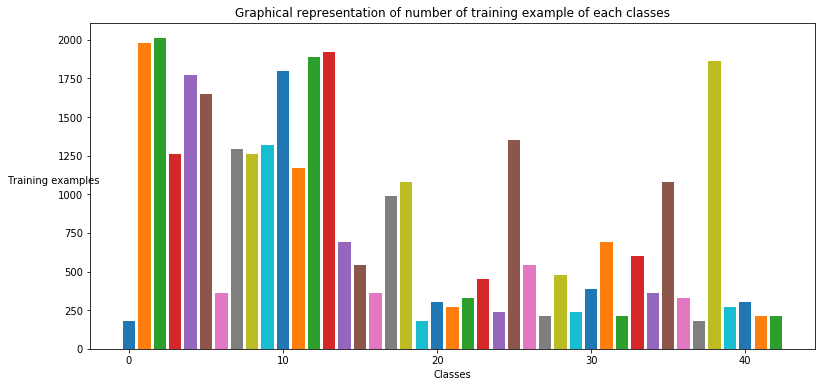

In [24]:
%matplotlib inline
l = Counter(y_train)
print()
plt.figure(figsize=(13, 6))
plt.ylabel('Training examples',rotation='horizontal')
plt.title('Graphical representation of number of training example of each classes')
plt.xlabel('Classes')
for i in range(n_classes):
    plt.bar(i,l.get(i),0.8)

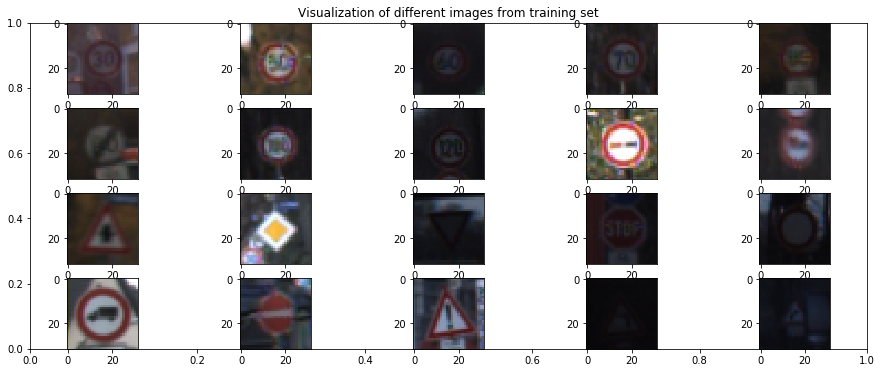

In [25]:
fig=plt.figure(figsize=(15, 6))
columns = 5
rows = 4
print()
plt.title('Visualization of different images from training set')
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[np.where(y_train==i)[0][0]])
plt.show()

* In first visulization we can see that training set is distributed propperly for various classes.
* Second visulization shows traffic signs from different classes.

### Step 4: Architecture Design

#### Pre-process the Data Set

In [26]:
#Pre-processing training data

X_train = 0.299*X_train[:,:,:,0] + 0.587*X_train[:,:,:,1] + 0.114*X_train[:,:,:,2]
X_train = X_train.reshape(X_train.shape + (1,))
X_train = (X_train - 128.0) / 128.0

#Pre-processing validation data

X_valid = 0.299*X_valid[:,:,:,0] + 0.587*X_valid[:,:,:,1] + 0.114*X_valid[:,:,:,2]
X_valid = X_valid.reshape(X_valid.shape + (1,))
X_valid = (X_valid - 128.0) / 128.0

#Pre-processing test data

X_test = 0.299*X_test[:,:,:,0] + 0.587*X_test[:,:,:,1] + 0.114*X_test[:,:,:,2]
X_test = X_test.reshape(X_test.shape + (1,))
X_test = (X_test - 128.0) / 128.0

#Shuffling training set
X_train,y_train = shuffle(X_train,y_train)

#### Model Architecture

In [27]:
EPOCHS = 40
BATCH_SIZE = 128

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 32x32x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    #fc0 = tf.nn.dropout(fc0,0.5)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    fc1 = tf.nn.dropout(fc1,keep_prob)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    #fc2 = tf.nn.dropout(fc2,0.5)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

#### Defining operations

In [28]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.002

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Step 5: Train and test

#### Evaluating a model

In [29]:
saver = tf.train.Saver()
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Training a model

Training...

EPOCH 1 ...
Validation Accuracy = 0.798
Train_acc:  0.798185940557

EPOCH 2 ...
Validation Accuracy = 0.902
Train_acc:  0.90226757321

EPOCH 3 ...
Validation Accuracy = 0.909
Train_acc:  0.909070295055

EPOCH 4 ...
Validation Accuracy = 0.932
Train_acc:  0.931972789143

EPOCH 5 ...
Validation Accuracy = 0.933
Train_acc:  0.933106575964

EPOCH 6 ...
Validation Accuracy = 0.948
Train_acc:  0.948072562629

EPOCH 7 ...
Validation Accuracy = 0.945
Train_acc:  0.944897959184

EPOCH 8 ...
Validation Accuracy = 0.954
Train_acc:  0.953741496599

EPOCH 9 ...
Validation Accuracy = 0.957
Train_acc:  0.957369614512

EPOCH 10 ...
Validation Accuracy = 0.948
Train_acc:  0.948299319728

EPOCH 11 ...
Validation Accuracy = 0.959
Train_acc:  0.958503401361

EPOCH 12 ...
Validation Accuracy = 0.955
Train_acc:  0.954648526077

EPOCH 13 ...
Validation Accuracy = 0.955
Train_acc:  0.954875283447

EPOCH 14 ...
Validation Accuracy = 0.949
Train_acc:  0.949433106576

EPOCH 15 ...
Validation Accurac

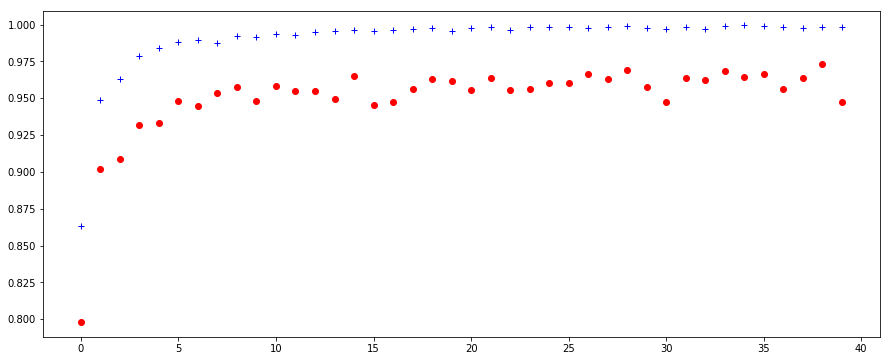

In [30]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    plt.figure(figsize=(15, 6))
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        train = evaluate(X_train, y_train)
        
        plt.plot(i,validation_accuracy,'ro')
        plt.plot(i,train,'b+')
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train_acc: ", validation_accuracy)
        print()
    saver.save(sess, './lenet')
    print("Model saved")

#### Testing pipeline

In [31]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


### Step 6: Test a Model on New Images

#### Load and Output the Images

In [32]:
X_new = []
for i in range(1,9):
    im = cv2.imread("./examples/Image"+str(i)+".jpg")
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    im = misc.imresize(im, (32, 32))
    X_new.append(im)
    
X_new = np.asarray(X_new)

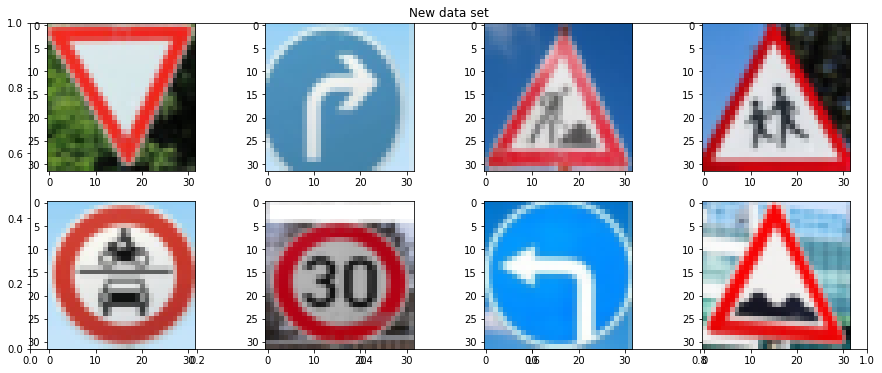

In [33]:
fig=plt.figure(figsize=(15, 6))
columns = 4
rows = 2
plt.title('New data set')
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_new[j])
    j+=1
plt.show()

#pre-process

X_newt = 0.299*X_new[:,:,:,0] + 0.587*X_new[:,:,:,1] + 0.114*X_new[:,:,:,2]
X_newt = X_newt.reshape(X_newt.shape + (1,))
X_newt = (X_newt - 128.0) / 128.0

#### Predict the Sign Type for Each Image

In [34]:
#y_new = [13,33,25,28,44,]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    scores = sess.run(logits, feed_dict={x: X_newt, keep_prob:1})
    scores = tf.nn.softmax(scores)
    scores = tf.nn.top_k(scores,k=5)
    scores = sess.run(scores)

#### Analyze Performance

In [35]:
#Importing CSV file

import csv
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    mydict = {rows[0]:rows[1] for rows in reader}

#### Output Top 5 Softmax Probabilities For Each Image Found on the Web

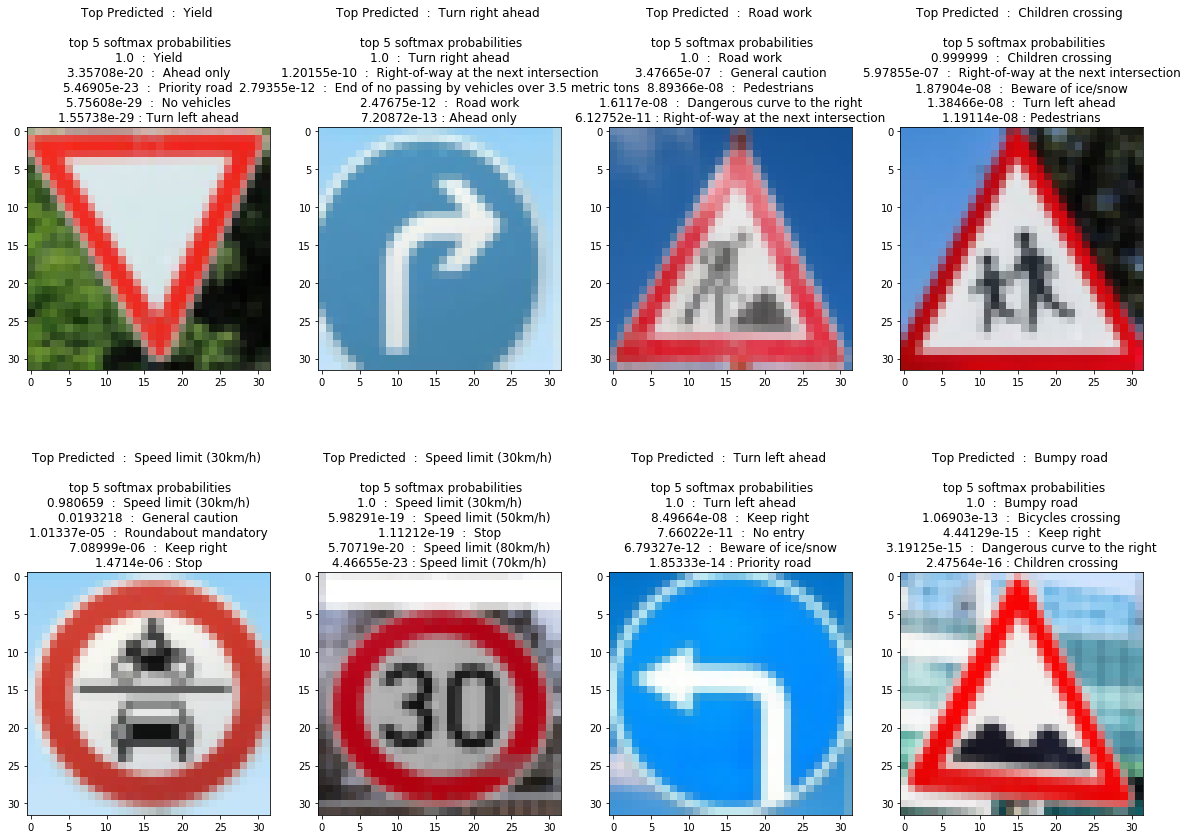

In [36]:
fig=plt.figure(figsize=(20, 15))
columns = 4
rows = 2
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.title('Top Predicted  :  '+str(mydict[str(scores[1][j][0])])+' \n\n top 5 softmax probabilities'
             + '\n' + str(scores[0][j][0]) + '  :  ' +str(mydict[str(scores[1][j][0])])
              +'\n' + str(scores[0][j][1]) + '  :  ' +str(mydict[str(scores[1][j][1])])
              +'\n'+ str(scores[0][j][2]) + '  :  ' +str(mydict[str(scores[1][j][2])])
              +'\n'+ str(scores[0][j][3]) + '  :  ' +str(mydict[str(scores[1][j][3])])
              +'\n'+ str(scores[0][j][4])+ ' : ' +str(mydict[str(scores[1][j][4])])
             )
    plt.imshow(X_new[j])
    j+=1
plt.show()